In [ ]:
!pip install --upgrade transformers


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

#Load the Excel file again
excel_path = "Data1.xlsx"
df_excel = pd.read_excel(excel_path)

#Display first few rows and column names
df_excel.head(), df_excel.columns

#Keep only the first two useful columns: class and sms
df_cleaned = df_excel[['class', 'sms']].dropna()

#Save to csv file for later use
df_cleaned.to_csv("fixed_data.csv", index=False)


**Bag of words with Multinomial Naive bayes**

In [ ]:
#Load the cleaned dataset
df = pd.read_csv("/content/fixed_data.csv")

#Split into features and labels
X = df['sms']
y = df['class']

#Split into training and testing sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Convert text to numeric using Bag of Words
vectorizer = CountVectorizer()
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

#Train a Naive Bayes classifier
model = MultinomialNB()
model.fit(X_train_vectors, y_train)

#Make predictions
y_pred = model.predict(X_test_vectors)

#Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8805104408352669

Classification Report:
               precision    recall  f1-score   support

         ham       0.89      0.79      0.83       326
        spam       0.88      0.94      0.91       536

    accuracy                           0.88       862
   macro avg       0.88      0.86      0.87       862
weighted avg       0.88      0.88      0.88       862



TF-IDF with Multinomial Naive Bayes




In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

#Load the cleaned CSV
df = pd.read_csv("/content/fixed_data.csv")

#Features and labels
X = df['sms']
y = df['class']

#Split: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Vectorize using TF-IDF
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

#Train the model
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

#Predict and evaluate
y_pred = model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.888631090487239

Classification Report:
               precision    recall  f1-score   support

         ham       0.93      0.77      0.84       326
        spam       0.87      0.96      0.91       536

    accuracy                           0.89       862
   macro avg       0.90      0.86      0.88       862
weighted avg       0.89      0.89      0.89       862



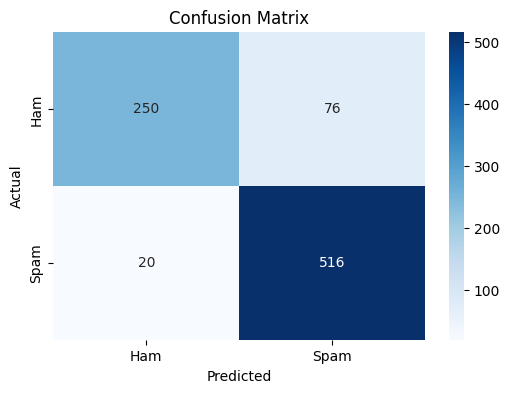

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

#Create the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['ham', 'spam'])

#Plot it
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


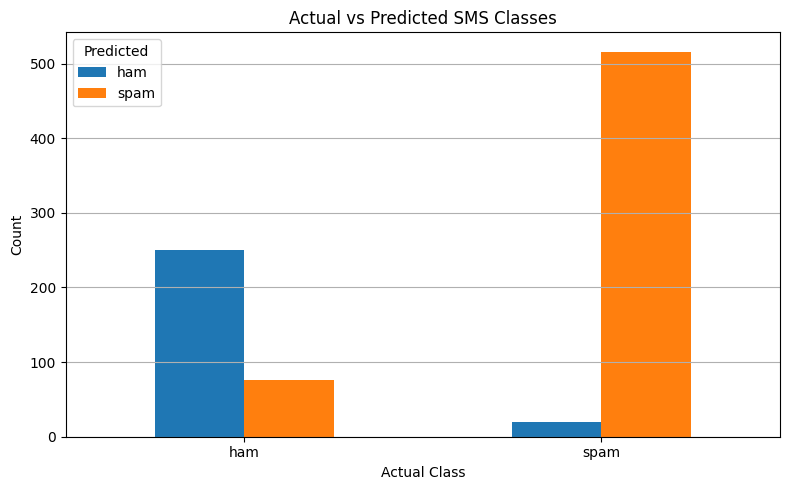

In [ ]:
#Compare predicted vs actual counts
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).value_counts().unstack().plot(kind='bar', figsize=(8,5))
plt.title("Actual vs Predicted SMS Classes")
plt.xlabel("Actual Class")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title="Predicted")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


In [ ]:
#Test on a custom message
sample = ["Dear Customer, your Bank AL Habib Account (0254-0078--50-8) has been debited with the amount PKR 320000.00, dated: 30/12/2024."]
sample_tfidf = tfidf.transform(sample)
print("Prediction:", model.predict(sample_tfidf)[0])  # Should return 'ham'


Prediction: ham


In [ ]:
#Test on a custom message
sample = ["Apka 4G bundle khatam ho chuka hai.Aap ka aaj ka muft 50MB 3G Internet khatam ho chuka hai. Bundle hasil karnay k liyah 345 per call karen"]
sample_tfidf = tfidf.transform(sample)
print("Prediction:", model.predict(sample_tfidf)[0])  # Should return 'spam'


Prediction: spam



**Applied Cleaning on dataset also improved upon test train split by using stratified split from now onwards**

In [ ]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

#Load and clean the Excel data
df = pd.read_csv("/content/fixed_data.csv")


def clean_text(text):
    text = text.lower()  # Convert to lowercase

    # Remove unwanted characters but keep useful ones like @ / Rs
    text = re.sub(r'[^a-z0-9@/:#\s]', ' ', text)  # Allow a-z, 0-9, @, /, :, spaces

    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

#Apply cleaning
df['sms'] = df['sms'].apply(clean_text)


#TF-IDF Vectorization
tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=5000, min_df=3, max_df=0.9, sublinear_tf=True)
X = tfidf.fit_transform(df['sms'])
y = df['class']

#Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


**Using Logistic regression after TF-IDF**

In [ ]:

#Grid search for best Logistic Regression parameter
param_grid = {'C': [0.001, 0.01, 0.1, 1]}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid.fit(X_train, y_train)

#Best model predictions
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)


print("Testing Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9048723897911833

Classification Report:
               precision    recall  f1-score   support

         ham       0.95      0.78      0.86       314
        spam       0.89      0.97      0.93       548

    accuracy                           0.90       862
   macro avg       0.92      0.88      0.89       862
weighted avg       0.91      0.90      0.90       862



In [ ]:
#Test on a custom message
sample = [clean_text("Apka 4G bundle khatam ho chuka hai.Aap ka aaj ka muft 50MB 3G Internet khatam ho chuka hai. Bundle hasil karnay k liyah 345 per call karen")]

sample_tfidf = tfidf.transform(sample)
print("Prediction:", best_model.predict(sample_tfidf)[0])  # Should return 'spam'


Prediction: spam


In [ ]:
#Test on a custom message
sample = [clean_text("kia musibat hai")]

sample_tfidf = tfidf.transform(sample)
print("Prediction:", best_model.predict(sample_tfidf)[0])  # Should return 'ham'


Prediction: ham



**Training accuracy**




In [ ]:
y_train_pred = best_model.predict(X_train)
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))


Training Accuracy: 0.9265815438189204


**The training and test accuracy both above 90% shows that model is not underfitting**

**Summary:**


---



**Situation	Interpretation**
1.   **Low train + low test accuracy =	Underfitting**
2.  **High train + low test accuracy =	Overfitting**
3.   **High and similar train/test accuracy	Good = generalization**

In [ ]:
print("Cross-validation scores:", grid.cv_results_['mean_test_score'])


Cross-validation scores: [0.63580951 0.65815233 0.84126375 0.89204855]


**Training Curve**

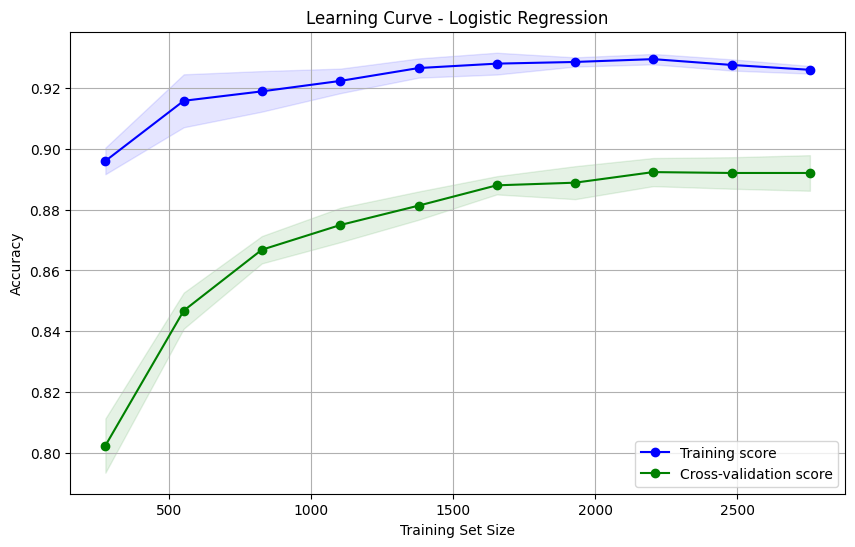

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import numpy as np

#Generate learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train,
    cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

#Compute mean and std
train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

#Plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, val_scores_mean, 'o-', color='green', label='Cross-validation score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color='green')
plt.title('Learning Curve - Logistic Regression')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [ ]:
#Test on a custom message
sample = ["Dear Customer, your Bank AL Habib Account (0254-0078--50-8) has been debited with the amount PKR 320000.00, dated: 30/12/2024."]
sample_tfidf = tfidf.transform(sample)
print("Prediction:", best_model.predict(sample_tfidf)[0])  # Should return 'ham'

Prediction: ham


**Printing with confidence score**

In [ ]:
import numpy as np

message = "Congratulations! You won."

cleaned = clean_text(message)

vector = tfidf.transform([cleaned])

#Predict probability
proba = best_model.predict_proba(vector)[0]  #[ham_prob, spam_prob]

#Get predicted class and confidence
classes = best_model.classes_               # ['ham', 'spam']
max_index = np.argmax(proba)                # Index of highest probability
label = classes[max_index]
confidence = round(proba[max_index] * 100, 2)

print(f"The message is classified as '{label}' with {confidence}% confidence.")


The message is classified as 'ham' with 80.16% confidence.


In [ ]:
import joblib

#Save model and vectorizer
joblib.dump(best_model, 'logistic_model.pkl')
joblib.dump(tfidf, 'vectorizer.pkl')


['vectorizer.pkl']

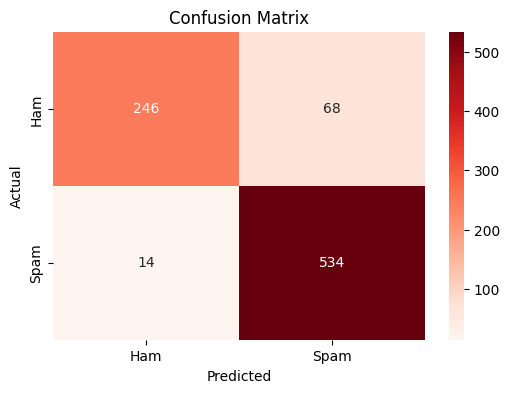

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

#Create the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['ham', 'spam'])

#Plot it
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


**Multinomial Naive Bayes with TF-IDF**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report


#Train the model
model = MultinomialNB()
model.fit(X_train, y_train)

#Predict and evaluate
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.888631090487239

Classification Report:
               precision    recall  f1-score   support

         ham       0.92      0.76      0.83       314
        spam       0.87      0.96      0.92       548

    accuracy                           0.89       862
   macro avg       0.90      0.86      0.87       862
weighted avg       0.89      0.89      0.89       862



In [ ]:
y_train_pred = model.predict(X_train)
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))


Training Accuracy: 0.8975623911781776


**Ensembling**

In [ ]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(estimators=[
    ('lr', LogisticRegression(C=0.1, max_iter=1000)),
    ('nb', MultinomialNB())
], voting='soft')

ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)


In [ ]:
from sklearn.metrics import accuracy_score

print("Ensemble Accuracy:", accuracy_score(y_test, y_pred))


Ensemble Accuracy: 0.8851508120649652


In [ ]:
from sklearn.metrics import classification_report

print("Classification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

         ham       0.94      0.73      0.82       314
        spam       0.86      0.97      0.92       548

    accuracy                           0.89       862
   macro avg       0.90      0.85      0.87       862
weighted avg       0.89      0.89      0.88       862



In [ ]:
y_train_pred = ensemble.predict(X_train)
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))


Training Accuracy: 0.8871154962275102


In [ ]:
#Test on a custom message
sample = [clean_text("kia musibat hai")]

sample_tfidf = tfidf.transform(sample)
print("Prediction:", ensemble.predict(sample_tfidf)[0])  # Should return 'spam'

Prediction: ham


**Using Ensemble of LR, MultinomialNB aned RF**

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

ensemble = VotingClassifier(estimators=[
    ('lr', LogisticRegression(C=0.1, max_iter=1000)),
    ('nb', MultinomialNB()),
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42))
], voting='soft')

ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

print("Ensemble Accuracy:", accuracy_score(y_test, y_pred))


Ensemble Accuracy: 0.87122969837587


**Using Random forest after TF-IDF**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

#Predict with Random Forest
y_pred = rf_model.predict(X_test)

#Evaluate Random Forest

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))




Accuracy: 0.9350348027842227

Classification Report:
               precision    recall  f1-score   support

         ham       0.90      0.92      0.91       314
        spam       0.96      0.94      0.95       548

    accuracy                           0.94       862
   macro avg       0.93      0.93      0.93       862
weighted avg       0.94      0.94      0.94       862



In [ ]:
y_train_pred = rf_model.predict(X_train)
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))

Training Accuracy: 0.9866511897852582


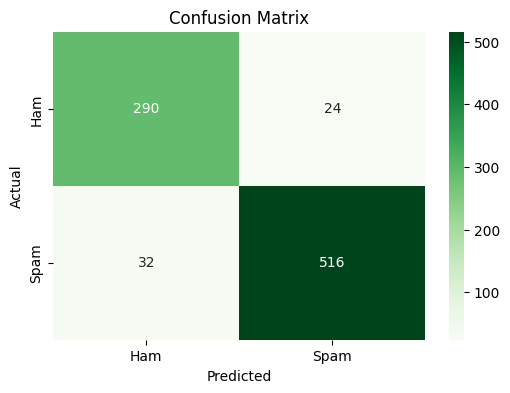

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

#Create the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['ham', 'spam'])

#Plot it
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
